In [33]:
import pandas as pd

# Load the Excel file
xl = pd.ExcelFile("LME Approved Brands (2).xlsx")

# Get the sheet names
sheet_names = xl.sheet_names
sheet_names

['Copper - Grade A',
 'Lead',
 'Special High Grade Zinc',
 'Tin',
 'Primary Nickel',
 'High Grade Primary Aluminium',
 'Aluminium Alloy',
 'NASAAC',
 'Cobalt']

In [34]:
# A dictionary to hold the dataframes
dataframes = {}

# Loop over the sheet names, loading and cleaning each one
for sheet_name in sheet_names:
    df = pd.read_excel("LME Approved Brands (2).xlsx", sheet_name=sheet_name, skiprows=5)
    dataframes[sheet_name] = df

# Display a sample from each dataframe
dataframe_samples = {sheet_name: df.head() for sheet_name, df in dataframes.items()}
dataframe_samples

{'Copper - Grade A':    Country/Region  Brand LMEsword Code   \
 0       Australia    ISA            ISA   
 1       Australia  OLYDA          OLYDA   
 2         Austria    BRX            BRX   
 3         Belgium   OLEN           OLEN   
 4          Brazil    CbM            CBM   
 
                                   Producer    Deliverable Shape  \
 0                      Mount Isa Mines Ltd  Full plate cathodes   
 1      BHP Olympic Dam Corporation Pty Ltd  Full plate cathodes   
 2  Montanwerke Brixlegg Aktiengesellschaft  Full plate cathodes   
 3                Aurubis Belgium n.v./s.a.  Full plate cathodes   
 4                        Paranapanema S.A.  Full plate cathodes   
 
   Warrant Issuance Last Warrantable Date Special Notes  
 0      WARRANTABLE                   NaT           NaN  
 1      WARRANTABLE                   NaT           NaN  
 2      WARRANTABLE                   NaT           NaN  
 3      WARRANTABLE                   NaT           NaN  
 4      WARRAN

In [35]:
#Create a combined dataframe listing the sheet material in a new column
combined_df = pd.concat(
    [df.assign(material=sheet_name) for sheet_name, df in dataframes.items()],
    ignore_index=True
)

# Save the combined dataframe to a CSV file
combined_df.to_csv("combined_data.csv", index=False)

combined_df.head()

,Country/Region,Brand,LMEsword Code,Producer,Deliverable Shape,Warrant Issuance,Last Warrantable Date,Special Notes,material,Country/Region,...,GRADES,99.97,99.985,99.99,99.97.1,99.985.1,99.99.1,99.994,99.97.2,99.995
0,Australia,ISA,ISA,Mount Isa Mines Ltd,Full plate cathodes,WARRANTABLE,NaT,NaN,Copper - Grade A,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Australia,OLYDA,OLYDA,BHP Olympic Dam Corporation Pty Ltd,Full plate cathodes,WARRANTABLE,NaT,NaN,Copper - Grade A,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Austria,BRX,BRX,Montanwerke Brixlegg Aktiengesellschaft,Full plate cathodes,WARRANTABLE,NaT,NaN,Copper - Grade A,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Belgium,OLEN,OLEN,Aurubis Belgium n.v./s.a.,Full plate cathodes,WARRANTABLE,NaT,NaN,Copper - Grade A,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Brazil,CbM,CBM,Paranapanema S.A.,Full plate cathodes,WARRANTABLE,NaT,NaN,Copper - Grade A,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
# Select only the desired columns
trimmed_df = combined_df[["Producer","Brand","material"," Country/Region"]]
trimmed_df = trimmed_df.dropna(subset=['Producer'])
# Save the cleaned dataframe to a new CSV file
trimmed_df.to_csv("trimmed_data.csv", index=False)



In [37]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
import numpy as np

# 1) Load the Data
company_list = pd.read_excel('Data (2).xlsx')
company_list['Company'] = company_list['Company'].astype(str).fillna('') # Replace NaN values with empty strings

# 2) Create Parent Company Column: Extract values within parentheses, excluding specific regions
def extract_parent_company(value):
    matches = re.findall(r'\(([^)]+)\)', value)
    for match in matches:
        if match not in ['Australia', 'Uk', 'Europe', 'Holdings', 'the', 'Myanmar', 'U.K.', 'Thailand', 'Switzerland','Sales']:
            return match
    return None

company_list['Parent Company'] = company_list['Company'].apply(extract_parent_company)

# 3) Data Cleaning: Remove phrases "part of" and "formerly" from the "Parent Company" column
company_list['Parent Company'] = company_list['Parent Company'].apply(lambda x: x.replace("part of", "").replace("formerly", "").strip() if pd.notnull(x) else x)

# Function to create the matching column based on a given similarity threshold
def create_matching_column(combined_text, vectorizer, similarity_threshold, column_name):
    tfidf_matrix = vectorizer.fit_transform(combined_text)
    vectors_a = tfidf_matrix[:len(company_list)]
    vectors_b = tfidf_matrix[len(company_list):]
    similarities = cosine_similarity(vectors_b, vectors_a)
    matching_column = [company_list[column_name].iloc[np.argmax(row)] if max(row) > similarity_threshold else None for row in similarities]
    return matching_column

vectorizer = TfidfVectorizer()

# Load data_cleaned DataFrame (can be loaded again or continued from previous operations)
data_cleaned = pd.read_csv('trimmed_data.csv')
data_cleaned['Producer'] = data_cleaned['Producer'].fillna('') # Replace NaN values with empty strings

# 4) Process for Creating the Matching Companies Column 90%
combined_text_companies = pd.concat([company_list['Company'], data_cleaned['Producer']], ignore_index=True)
data_cleaned['Matching Company 90%'] = create_matching_column(combined_text_companies, vectorizer, 0.9, 'Company')

# 5) Process for Creating the Matching Cleaned Parent Companies 50%
combined_text_parent_cleaned = pd.concat([company_list['Parent Company'].fillna(''), data_cleaned['Producer']], ignore_index=True)
data_cleaned['Matching Parent Company Cleaned 50%'] = create_matching_column(combined_text_parent_cleaned, vectorizer, 0.5, 'Parent Company')

# 6) Process for Creating the Matching Companies Column 90%
combined_text_companies = pd.concat([company_list['Company'], data_cleaned['Brand']], ignore_index=True)
data_cleaned['Matching Company_brand 90%'] = create_matching_column(combined_text_companies, vectorizer, 0.9, 'Company')

# 7) Process for Creating the Matching Cleaned Parent Companies 50%
combined_text_parent_cleaned = pd.concat([company_list['Parent Company'].fillna(''), data_cleaned['Brand']], ignore_index=True)
data_cleaned['Matching Parent Company_Brand Cleaned 50%'] = create_matching_column(combined_text_parent_cleaned, vectorizer, 0.5, 'Parent Company')


# Save the updated data_cleaned DataFrame if needed
data_cleaned.to_csv('matched_results.csv', index=False)


In [38]:
import pandas as pd

# Step 1: Load the matched_results.xlsx file
matched_results = pd.read_csv('matched_results.csv')

# Step 2: Create the "Match" column
matched_columns = ['Matching Company 90%', 'Matching Parent Company Cleaned 50%', 'Matching Company_brand 90%', 'Matching Parent Company_Brand Cleaned 50%']
matched_results['Match'] = matched_results[matched_columns].apply(lambda row: 1 if any(pd.notnull(cell) for cell in row) else 0, axis=1)

# Step 4: Import the values from the columns: Location, Category, and Website based on the matched company

# Create empty columns for Location, Category, and Website in matched_results
matched_results['Location'] = None
matched_results['Category'] = None
matched_results['Website'] = None

# Function to fetch data for matched companies
def fetch_data(row):
    for col in matched_columns:
        matched_company = row[col]
        if pd.notnull(matched_company):
            match_data = company_list[company_list['Company'] == matched_company]
            if not match_data.empty:
                row['Location'] = match_data['Location'].values[0]
                row['Category'] = match_data['Category'].values[0]
                row['Website'] = match_data['Website'].values[0]
                break
    return row

# Apply the function to rows with Match = 1
matched_results = matched_results.apply(lambda row: fetch_data(row) if row['Match'] == 1 else row, axis=1)

matched_results.head()



,Producer,Brand,material,Country/Region,Matching Company 90%,Matching Parent Company Cleaned 50%,Matching Company_brand 90%,Matching Parent Company_Brand Cleaned 50%,Match,Location,Category,Website
0,Mount Isa Mines Ltd,ISA,Copper - Grade A,Australia,NaN,NaN,ISA Group,ISA Group,1,United States of America,Health Sector: General,http://www.isa.com.co
1,BHP Olympic Dam Corporation Pty Ltd,OLYDA,Copper - Grade A,Australia,NaN,NaN,NaN,NaN,0,None,None,None
2,Montanwerke Brixlegg Aktiengesellschaft,BRX,Copper - Grade A,Austria,NaN,NaN,NaN,NaN,0,None,None,None
3,Aurubis Belgium n.v./s.a.,OLEN,Copper - Grade A,Belgium,NaN,NaN,NaN,NaN,0,None,None,None
4,Paranapanema S.A.,CbM,Copper - Grade A,Brazil,NaN,NaN,NaN,NaN,0,None,None,None


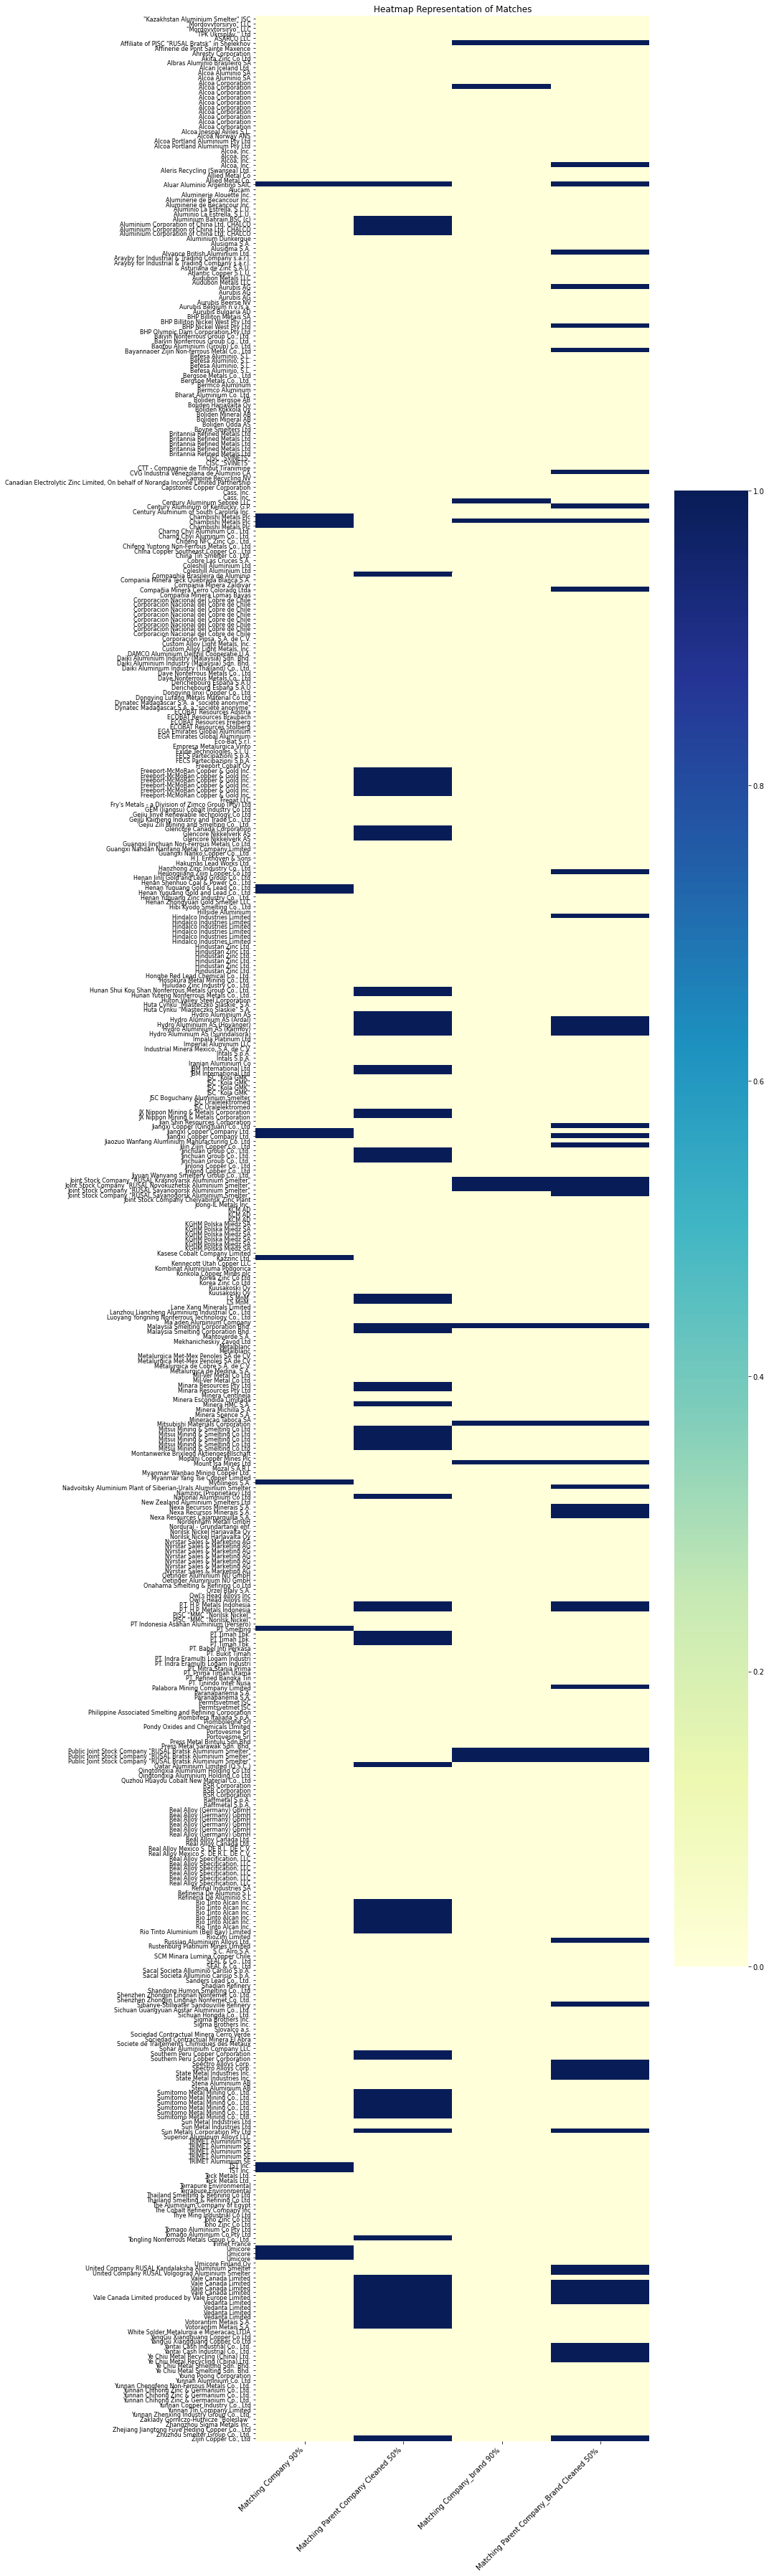

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the updated_matched_results.xlsx file
file_path = 'matched_results.csv'
updated_matched_results = pd.read_csv(file_path)

# Sort the DataFrame by company names (Producer) alphabetically
updated_matched_results = updated_matched_results.sort_values(by='Producer')

# Specify the columns for matching
matched_columns = ['Matching Company 90%', 'Matching Parent Company Cleaned 50%', 'Matching Company_brand 90%', 'Matching Parent Company_Brand Cleaned 50%']

# Create a DataFrame with binary values representing the presence of matches in the specified columns
heatmap_data = updated_matched_results[matched_columns].applymap(lambda x: 1 if pd.notnull(x) else 0)

# Plotting the heatmap with company names on the y-axis
plt.figure(figsize=(15, 50), facecolor='white') # Set white background
sns.heatmap(heatmap_data, cmap="YlGnBu", cbar=True, yticklabels=updated_matched_results['Producer'])
plt.title("Heatmap Representation of Matches")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()

# Save the expanded heatmap with readable y-axis labels as an image file
expanded_heatmap_image_path = 'expanded_heatmap_image.png'
plt.savefig(expanded_heatmap_image_path, dpi=300, facecolor='white')

plt.show()
